# Figure 3h

In [1]:
%load_ext autoreload
%autoreload 2

In [179]:
from requirements import *
from segger.data.parquet._utils import (
    filter_transcripts,
    load_settings,
)
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import preprocess_rapids
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.plot_volcano import plot_volcano
from sg_utils.pl.utils import lighten_color
from sklearn.metrics import adjusted_rand_score

## Get cell consistencies for signaling pathways

In [3]:
# Read in all transcripts
tenx_col = '10x_nucleus_id'
segger_col = 'segger_cell_id_HDE46PBXJB'
baysor_col = 'baysor_cell_id_c=0.5'
cellpose_col = 'cellpose_cell_id'

transcripts = cudf.read_parquet(
    data_dir / 'labeled_transcripts.parquet',
    filters=[[('cellpose_cell_type', '==', 'Epithelial/Cancer')]],
    columns=[
        cellpose_col, segger_col, baysor_col, tenx_col,
        'feature_name', segger_col.replace('cell_id', 'score'),
    ],
)

In [191]:
# Get signaling pathway genes
panel = pd.read_csv(data_dir / 'gene_information.csv', index_col='gene')
genes = ['JAK1', 'JAK2', 'JAK3', 'STAT1', 'STAT2', 'STAT3']
panel.loc[genes, 'annotation'] = 'JAK/STAT Signaling'
panel['annotation'] = panel['annotation'].replace({
    'Notch signaling': 'NOTCH Signaling',
})
panel = panel[panel['annotation'].isin([
    'JAK/STAT Signaling',
    'Tumor-Immune Interactions',
    'NOTCH Signaling'
])]

In [192]:
# Get ARI for each signaling pathway and segmentation
scores = []
for pathway, group in tqdm(panel.groupby('annotation')):
    genes = group.index
    for g in genes:
        for col in [segger_col, baysor_col, tenx_col]:
            mask_1 = transcripts['feature_name'] == g
            mask_2 = ~transcripts[cellpose_col].isna()
            mask_2 &= ~transcripts[col].isna()
            if 'segger' in col:
                mask_2 &= transcripts[col.replace('cell_id', 'score')].ge(0.33)
            mask = mask_1 & mask_2
            a = transcripts.loc[mask, cellpose_col].to_pandas()
            b = transcripts.loc[mask, col].to_pandas()
            score = adjusted_rand_score(a, b)
            frac = 1 - transcripts.loc[mask_1, col].isna().mean()
            segmentation = col.split('_')[0]
            scores.append([g, segmentation, pathway, score, frac])

# Reformat dataframe
columns = ['Gene', 'Segmentation', 'Pathway', 'ARI', 'Fraction']
summary = pd.DataFrame(scores, columns=columns)
summary['Segmentation'] = summary['Segmentation'].replace({
    'baysor': 'Baysor',
    '10x': '10X Nucleus',
    'segger': 'Segger Embedding'
})

100%|██████████| 3/3 [00:21<00:00,  7.06s/it]


In [200]:
gb.groups

{('10X Nucleus', 'JAK/STAT Signaling'): [2, 5, 8, 11, 14, 17], ('10X Nucleus', 'NOTCH Signaling'): [20, 23, 26, 29, 32, 35, 38, 41, 44], ('10X Nucleus', 'Tumor-Immune Interactions'): [47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95], ('Baysor', 'JAK/STAT Signaling'): [1, 4, 7, 10, 13, 16], ('Baysor', 'NOTCH Signaling'): [19, 22, 25, 28, 31, 34, 37, 40, 43], ('Baysor', 'Tumor-Immune Interactions'): [46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94], ('Segger Embedding', 'JAK/STAT Signaling'): [0, 3, 6, 9, 12, 15], ('Segger Embedding', 'NOTCH Signaling'): [18, 21, 24, 27, 30, 33, 36, 39, 42], ('Segger Embedding', 'Tumor-Immune Interactions'): [45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93]}

In [204]:
gb = summary.groupby(['Segmentation', 'Pathway'])
sp.stats.ttest_ind(
    gb.get_group(('Baysor', 'Tumor-Immune Interactions'))['ARI'],
    gb.get_group(('Segger Embedding', 'Tumor-Immune Interactions'))['ARI'],
)

TtestResult(statistic=-2.382219378201954, pvalue=0.023320827201946552, df=32.0)

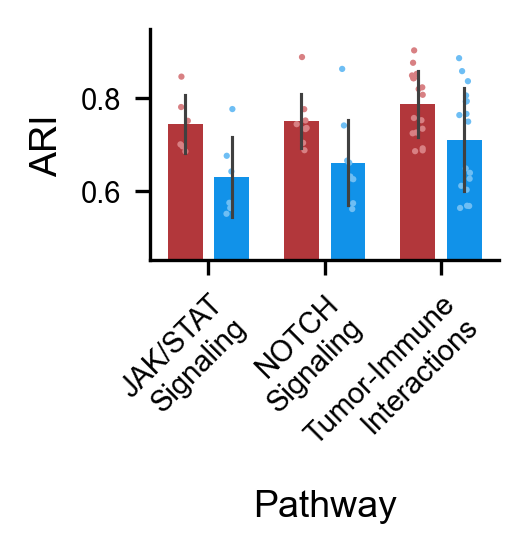

In [208]:
fig, ax = plt.subplots(
    1, 1, 
    figsize=(1.5, 1),
    sharex=True,
    gridspec_kw=dict(hspace=0.3),
)

# Plots
hue_order = ['Segger Embedding', 'Baysor']
palette = [named_colors[k] for k in hue_order]
shared_kwargs = dict(
    x='Pathway',
    y='ARI',
    hue='Segmentation',
    legend=False,
    hue_order=hue_order,
    ax=ax
)
sns.barplot(
    summary,
    **shared_kwargs,
    width=0.8,
    saturation=1,
    gap=0.25,
    errorbar=("sd", 1),
    palette=palette,
    err_kws=dict(color="0.25", linewidth=0.75, zorder=4),
)
palette=[lighten_color(p, 0.6) for p in palette]
sns.stripplot(summary, s=1.5, dodge=True, palette=palette, **shared_kwargs)

# Formatting
ax.set_ylim(summary['ARI'].min()-0.1)
ax.set_xticklabels(
    [l.get_text().replace(' ', '\n') for l in ax.get_xticklabels()],
    rotation=45, ha='right',
    rotation_mode='anchor'
)
fig.savefig(media_dir / 'figure_3h.svg')